## **Importing Libraries**

In [1]:
# Installing packages to read pdf and document(doc/docx)
# Installing Spacy  for Extracting the important text

!pip install pdfminer.six 
!pip install docx2txt
!pip install python-docx
!pip install spacy

In [2]:
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

import docx2txt
import io
import spacy
from spacy.matcher import Matcher
import en_core_web_sm

import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import operator

import glob

from gensim.summarization.summarizer import summarize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Iterating over the files in Resume folder and creating list**

In [4]:
fileName= []
for filename in glob.iglob('/content/drive/My Drive/Kaggle/ResumeRanker/Resume/*', recursive=True):
  fileName.append(filename)

fileName

['/content/drive/My Drive/Kaggle/ResumeRanker/Resume/AnushaViraj_Resume.pdf',
 '/content/drive/My Drive/Kaggle/ResumeRanker/Resume/Monicaa_Kuppan_Resume.pdf',
 '/content/drive/My Drive/Kaggle/ResumeRanker/Resume/Shreya_Resume.pdf',
 '/content/drive/My Drive/Kaggle/ResumeRanker/Resume/Yashik_Resume.pdf',
 '/content/drive/My Drive/Kaggle/ResumeRanker/Resume/Reshma5yrsQAAnalyst.pdf',
 '/content/drive/My Drive/Kaggle/ResumeRanker/Resume/Rashmi_Java_5Yrs.docx']

## **Reading PDF as Text**

In [5]:
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as fh:
        # iterate over all pages of PDF document
        for page in PDFPage.get_pages(fh, caching=True, check_extractable=True):
            # creating a resoure manager
            resource_manager = PDFResourceManager()
            
            # create a file handle
            file_handle = io.StringIO()
            
            # creating a text converter object
            converter = TextConverter(
                                resource_manager, 
                                file_handle, 
                                codec='utf-8', 
                                laparams=LAParams()
                        )

            # creating a page interpreter
            page_interpreter = PDFPageInterpreter(
                                resource_manager, 
                                converter
                            )

            # process current page
            page_interpreter.process_page(page)
            
            # extract text
            text = file_handle.getvalue()
            yield text

            # close open handles
            converter.close()
            file_handle.close()

## **Reading document as Text**

In [6]:
def extract_text_from_doc(doc_path):
    temp = docx2txt.process(doc_path)
    text = [line.replace('\t', ' ') for line in temp.split('\n') if line]
    return ' '.join(text)

## **Iterating over Resume and fetching Text**

In [7]:
resumeList = []
for file in fileName:
  if '.pdf' in file:
    print("Reading resume for: {}".format(file))
    pdfText = ''
    for page in extract_text_from_pdf(file):
      pdfText += ' ' + page
    resumeList.append(pdfText)
  else:
    print("Reading resume for: {}".format(file))
    text = extract_text_from_doc(file)
    resumeList.append(text)

Reading resume for: /content/drive/My Drive/Kaggle/ResumeRanker/Resume/AnushaViraj_Resume.pdf
Reading resume for: /content/drive/My Drive/Kaggle/ResumeRanker/Resume/Monicaa_Kuppan_Resume.pdf
Reading resume for: /content/drive/My Drive/Kaggle/ResumeRanker/Resume/Shreya_Resume.pdf
Reading resume for: /content/drive/My Drive/Kaggle/ResumeRanker/Resume/Yashik_Resume.pdf
Reading resume for: /content/drive/My Drive/Kaggle/ResumeRanker/Resume/Reshma5yrsQAAnalyst.pdf
Reading resume for: /content/drive/My Drive/Kaggle/ResumeRanker/Resume/Rashmi_Java_5Yrs.docx


## **Creating pandas Dataframe**

In [8]:
resume = pd.DataFrame(resumeList, columns=['ResumeText'])
resume

,ResumeText
0,Anusha Viraj \nSenior Automation Engineer \n\...
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...


## **Extracting Name fom Text**

In [9]:
# load pre-trained model
nlp = spacy.load('en_core_web_sm')

# initialize matcher with a vocab
matcher = Matcher(nlp.vocab)

def extract_name(resume_text):
    nlp_text = nlp(resume_text)
    
    # First name and Last name are always Proper Nouns
    pattern = [{'POS': 'PROPN'}, {'POS': 'PROPN'}]
    
    matcher.add('NAME',  [pattern])
    
    matches = matcher(nlp_text)
    
    for match_id, start, end in matches:
        span = nlp_text[start:end]
        return span.text

In [10]:
nameList = []

for resumeItem in resumeList:
  fetchName = extract_name(resumeItem)
  nameList.append(fetchName)

In [11]:
resume['Name'] = nameList
resume

,ResumeText,Name
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari


## **Extact Mobile Numer**

**Handled Mobile Format:**

```
(+91) 1234567890
(954)3601488
(123) 456 7899
(123).456.7899
(123)-456-7899
+911234567890
+91 123 456 7890
+91 1234567890
09543601488
+91-1234567890
0-1234567890
0 1234567890
++91-9543601488
123-456-7899
123 456 7899
1234567899
0511-4405222
021-87888822
+8613012345678
03595-259506
03592 245902
03598245785
```



In [12]:
def extract_mobile_number(text):
    phone = re.findall(re.compile(r'[\(]?\+?\d[\)]?[\d -\.]{8,13}\d'), text)
    return phone

In [13]:
phoneNumber = []
for resumeItem in resumeList:
  phoneNo = extract_mobile_number(resumeItem)
  phoneNumber.append(phoneNo[0])

In [14]:
resume['PhoneNo'] = phoneNumber
resume

,ResumeText,Name,PhoneNo
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464


## **Extracting Years of Experience**

### **Using Regular Expression**

**Experience Years Handled**

```
6.6 years
6+ years
3+
8+ IT
5 years 8 months
7 year
```



In [15]:
# def extract_years_of_experience(text):
#   nlp_text = nlp(text)
#   experienceList = []
#   #experience = re.findall(re.compile(r'^([\d]{1})[ \.\+]+[\d]?[ ]?(years?)?([ ])*([\d]{1})*([ ])*(months?)?'), nlp_text)
#   experience = re.match(re.compile(r'^([\d]{1})[ \.\+]+[\d]?[ ]?(years?)?([ ])*([\d]{1})*([ ])*(months?)?'), nlp_text)
#   experienceList.append(experience)
#   return experienceList

In [16]:
# for resumeItem in resumeList:
#   exp = extract_years_of_experience(resumeItem)
#   print(exp)
#   experiences.append(exp)

# #experiences

In [17]:
# import nltk
# nltk.download('punkt')

In [18]:
# from nltk import word_tokenize
# from nltk.util import ngrams
# def get_ngrams(text, n):
#     n_grams = ngrams(word_tokenize(text), n)
#     return [ ' '.join(grams) for grams in n_grams]

# trigrams = get_ngrams(pdfText, 3 )
# trigrams

In [19]:
# for item in trigrams:
#   experience = re.findall(re.compile(r'^([\d]{1})[ \.\+]+[\d]?[ ]?(years?)?([ ])*([\d]{1})*([ ])*(months?)?'), item)  
#   exp = ''
#   for value in experience:
#     exp = ' '.join(exp)
#   print(exp)

### **Using Spacy Date Tag**

In [20]:
experiences = []
def extract_experience(text):
  experience = []
  exp = nlp(text)
  for ent in exp.ents:
    if ent.label_ == "DATE":
      experience.append(ent.text)
    else:
      continue
  return experience

In [21]:
for resumeItem in resumeList:
  exp = extract_experience(resumeItem)
  experiences.append(exp[0])

experiences

['8+ years',
 '\u200baround 8+ years',
 'around 5+ years',
 '12/2018',
 '5 years',
 'almost 5 years']

In [22]:
resume['Experience'] = experiences
resume

,ResumeText,Name,PhoneNo,Experience
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488,8+ years
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741,​around 8+ years
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408,around 5+ years
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598,12/2018
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866,5 years
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464,almost 5 years


## **Extracting Skills**

<p style="background-color: #FFEC8B;"><b> NOTE: Commented out single words as it was giving issues. Included on trigrams. The secondary skills have blank value which needs to be handled later</b></p>

In [23]:
skills = pd.read_excel("/content/drive/My Drive/Kaggle/ResumeRanker/SkillsRequired.xlsx")

#Check for Null values
for column in skills.columns:
  if (skills[column].isnull().sum() > 0):
    print("Column {} has {} null values.".format(column,skills[column].isnull().sum()), "\n")
    skills[column] = skills[column].fillna('blank')

# Convert Primary Skills to list and lower case
primarySkills = skills['PrimarySkills'].values.tolist()
for i in range(len(primarySkills)):
  primarySkills[i] = primarySkills[i].lower()
   
# Convert Secondary skills to list and lower case
secondarySkills = skills['GoodToHave'].values.tolist()
for i in range(len(secondarySkills)):
  secondarySkills[i] = secondarySkills[i].lower()
    

def extract_skills(resume_text):
    nlp_text = nlp(resume_text)
    chunks = nlp_text.noun_chunks

    # removing stop words and implementing word tokenization
    tokens = [token.text for token in nlp_text if not token.is_stop]

    primarySkillSet = []
    secondarySkillSet = []
  
    # check for bi-grams and tri-grams (example: machine learning)
    for token in chunks:
      token = token.text.lower().strip()
      if token in primarySkills:
        primarySkillSet.append(token)
      elif token in secondarySkills:
        secondarySkillSet.append(token)
      else:
        continue
          
    return primarySkillSet, secondarySkillSet

Column GoodToHave has 11 null values. 



In [24]:
candidatePrimarySkill = []
candidateSecondarySkill = []

for resumeItem in resumeList:
  sillExtracted = extract_skills(resumeItem)
  candidatePrimarySkill.append(sillExtracted[0])
  candidateSecondarySkill.append(sillExtracted[1])

print("Candidate Primary Skill: {}".format(candidatePrimarySkill))
print("Candidate Secondary SKill: {}".format(candidateSecondarySkill)) 

Candidate Primary Skill: [['automation', 'automation', 'automation', 'selenium', 'cucumber', 'automation', 'testng', 'junit', 'maven', 'automation testing', 'jira'], ['jenkins'], ['java', 'soap', 'java', 'java', 'java', 'soap'], ['automation', 'selenium', 'selenium', 'testng', 'maven', 'jenkins', 'jira', 'selenium', 'automation testing', 'selenium', 'automation testing', 'selenium', 'jenkins'], ['automation testing', 'cucumber', 'selenium', 'automation testing', 'testng', 'selenium', 'testng', 'jira', 'jira', 'selenium', 'jira', 'java', 'jira'], ['java', 'maven', 'api', 'java']]
Candidate Secondary SKill: [['python', 'python'], ['spring boot framework'], [], [], [], []]


In [25]:
resume['PrimarySkills'] = candidatePrimarySkill
resume

,ResumeText,Name,PhoneNo,Experience,PrimarySkills
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488,8+ years,"[automation, automation, automation, selenium,..."
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741,​around 8+ years,[jenkins]
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408,around 5+ years,"[java, soap, java, java, java, soap]"
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598,12/2018,"[automation, selenium, selenium, testng, maven..."
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866,5 years,"[automation testing, cucumber, selenium, autom..."
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464,almost 5 years,"[java, maven, api, java]"


## **Fetching Repeated Primary Skill for each candaidate**

In [26]:
candidateRepeatedSkill = []

for candidate in candidatePrimarySkill:
  skillDictionary = {i:candidate.count(i) for i in candidate}
  primarySkillDictionary = sorted(skillDictionary.items(),key=operator.itemgetter(1),reverse=True)
  candidateRepeatedSkill.append(primarySkillDictionary)

In [27]:
candidateRepeatedSkill

[[('automation', 4),
  ('selenium', 1),
  ('cucumber', 1),
  ('testng', 1),
  ('junit', 1),
  ('maven', 1),
  ('automation testing', 1),
  ('jira', 1)],
 [('jenkins', 1)],
 [('java', 4), ('soap', 2)],
 [('selenium', 5),
  ('jenkins', 2),
  ('automation testing', 2),
  ('automation', 1),
  ('testng', 1),
  ('maven', 1),
  ('jira', 1)],
 [('jira', 4),
  ('selenium', 3),
  ('automation testing', 2),
  ('testng', 2),
  ('cucumber', 1),
  ('java', 1)],
 [('java', 2), ('maven', 1), ('api', 1)]]

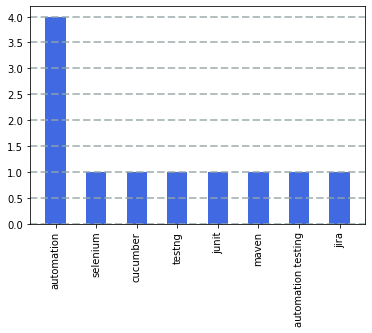

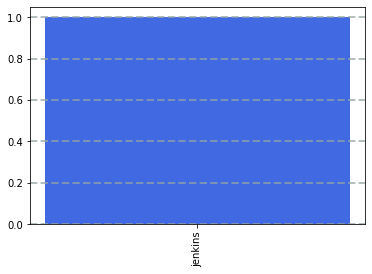

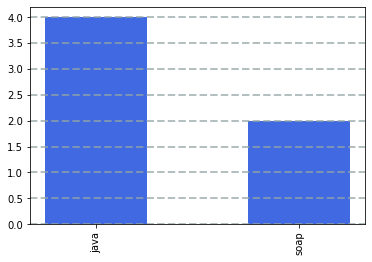

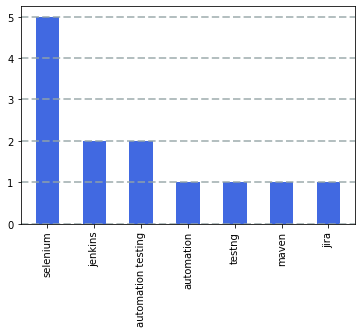

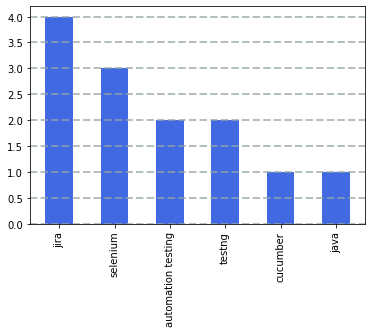

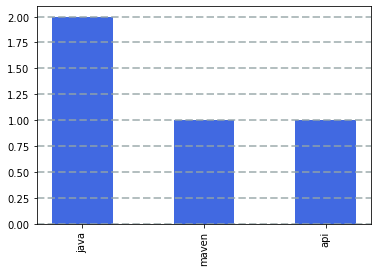

In [28]:
for candidate, i, name in zip(candidateRepeatedSkill, range(len(nameList)), nameList):
  top = candidate
  labels, yAxisValue = zip(*top)
  xAxisValue = np.arange(len(labels)) 
  plt.bar(xAxisValue, yAxisValue, width = 0.5, align='center', color = 'royalblue')
  plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
  plt.xticks(xAxisValue, labels, rotation = 90)
  plt.show()

## **Fetching the no of Primary Skills that Matched the Required Skills**

In [29]:
# candidateUniqueSkill = []

# for candidateSkill in candidatePrimarySkill:
#   print(candidateSkill)
#   uniqueSkillSet = set()
#   for values in candidateSkill:
#     print(values)
#     uniqueSkillSet.add(values)
#   candidateUniqueSkill.append(uniqueSkillSet)

# candidateUniqueSkill

In [30]:
candidateUniqueSkill = []

for candidateSkill in candidateRepeatedSkill:
  skill = []
  for skillName in candidateSkill:
    skill.append(skillName[0])
  candidateUniqueSkill.append(skill)

In [31]:
skillMatched = []

for matchedSkill in candidateUniqueSkill:  
  percentage = round((len(matchedSkill)/len(primarySkills))*100)
  skillMatched.append(percentage)

In [32]:
resume['%PrimarySkillMatch'] = skillMatched
resume

,ResumeText,Name,PhoneNo,Experience,PrimarySkills,%PrimarySkillMatch
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488,8+ years,"[automation, automation, automation, selenium,...",47
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741,​around 8+ years,[jenkins],6
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408,around 5+ years,"[java, soap, java, java, java, soap]",12
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598,12/2018,"[automation, selenium, selenium, testng, maven...",41
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866,5 years,"[automation testing, cucumber, selenium, autom...",35
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464,almost 5 years,"[java, maven, api, java]",18


## **Fetching the no of Secondary Skills that Matched the Required Skills**

In [33]:
candidateUniqueSecSkill = []

for candidateSkill in candidateSecondarySkill:
  uniqueSkillSet = set()
  for values in candidateSkill:
    if not values:
      uniqueSkillSet.add(0)
    else:
      uniqueSkillSet.add(values)
  candidateUniqueSecSkill.append(uniqueSkillSet)

candidateUniqueSecSkill

[{'python'}, {'spring boot framework'}, set(), set(), set(), set()]

In [34]:
SecSkillMatched = []

for matchedSkill in candidateUniqueSecSkill:  
  percentage = round((len(matchedSkill)/len(secondarySkills))*100)
  SecSkillMatched.append(percentage)

In [35]:
resume['%AdditionalSkillMatch'] = SecSkillMatched
resume

,ResumeText,Name,PhoneNo,Experience,PrimarySkills,%PrimarySkillMatch,%AdditionalSkillMatch
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488,8+ years,"[automation, automation, automation, selenium,...",47,6
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741,​around 8+ years,[jenkins],6,6
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408,around 5+ years,"[java, soap, java, java, java, soap]",12,0
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598,12/2018,"[automation, selenium, selenium, testng, maven...",41,0
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866,5 years,"[automation testing, cucumber, selenium, autom...",35,0
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464,almost 5 years,"[java, maven, api, java]",18,0


## **Scoring the Resume with Cosine Similarity**

In [36]:
jobDescription = extract_text_from_doc(r'/content/drive/My Drive/Kaggle/ResumeRanker/JobDescription.docx')
jobDescription

'Oracle Recruiting central automation team\xa0is looking for a\xa0Senior test automation engineer.\xa0The central automation team is responsible for building and maintaining the automation framework for all recruiting products under the HCM cloud business unit. We have a unique working environment where great engineers thrive & the team is made up of seasoned professionals who are open to adopting new innovative solutions. \xa0 As a Principal Test Automation Engineer, you are responsible for, ·\xa0\xa0\xa0\xa0\xa0\xa0\xa0Automate test cases using Selenium, Java, and BDD ·\xa0\xa0\xa0\xa0\xa0\xa0\xa0Design & tune the automation framework for robust automation development and stable automation executions ·\xa0\xa0\xa0\xa0\xa0\xa0\xa0Collaborate closely with the Quality Assurance Analysts to create and execute effective automation test suites \xa0 Qualifications ·\xa0\xa0\xa0\xa0\xa0\xa0\xa0Bachelor of Science, Computer Science/Engineering, or related discipline ·\xa0\xa0\xa0\xa0\xa0\xa0\

In [37]:
matchScore = []

def resume_cosine_score(text):
  text_list = [text, jobDescription]
  cv = CountVectorizer()
  count_matrix = cv.fit_transform(text_list)
  matchPercentage = cosine_similarity(count_matrix)[0][1] * 100
  matchPercentage = round(matchPercentage, 2) # round to two decimal
  #key = keywords(jobDescription, ratio=0.25)) 

  return matchPercentage

In [38]:
for resumeItem in resumeList:
  score = resume_cosine_score(resumeItem)
  matchScore.append(score)

In [39]:
resume['CosineScore'] = matchScore
resume

,ResumeText,Name,PhoneNo,Experience,PrimarySkills,%PrimarySkillMatch,%AdditionalSkillMatch,CosineScore
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488,8+ years,"[automation, automation, automation, selenium,...",47,6,63.60
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741,​around 8+ years,[jenkins],6,6,55.54
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408,around 5+ years,"[java, soap, java, java, java, soap]",12,0,59.78
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598,12/2018,"[automation, selenium, selenium, testng, maven...",41,0,60.90
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866,5 years,"[automation testing, cucumber, selenium, autom...",35,0,67.06
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464,almost 5 years,"[java, maven, api, java]",18,0,63.24


## **Total Score for Candidate**

In [40]:
resume["TotalScore"] = resume['%PrimarySkillMatch'] + resume['%AdditionalSkillMatch'] + resume['CosineScore']
resume

,ResumeText,Name,PhoneNo,Experience,PrimarySkills,%PrimarySkillMatch,%AdditionalSkillMatch,CosineScore,TotalScore
0,Anusha Viraj \nSenior Automation Engineer \n\...,Anusha Viraj,9543601488,8+ years,"[automation, automation, automation, selenium,...",47,6,63.60,116.60
1,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n...,Monicaa Kuppan,+91-9880650741,​around 8+ years,[jenkins],6,6,55.54,67.54
2,Shreya Anant Mahuli (MCA) \nE-M ail:shreyama...,Shreya Anant,9986309408,around 5+ years,"[java, soap, java, java, java, soap]",12,0,59.78,71.78
3,Yashik Narula\nProgrammer Analyst\nTo Achieve...,Yashik Narula,9962117598,12/2018,"[automation, selenium, selenium, testng, maven...",41,0,60.90,101.90
4,\n\n \n\n \n\n \n \nObjective\n\n \n\n \n\n...,IT Industry,+91-7799248866,5 years,"[automation testing, cucumber, selenium, autom...",35,0,67.06,102.06
5,Rashmi Kumari Email: er.rash.rashmi@gmail.com ...,Rashmi Kumari,+91 8904664464,almost 5 years,"[java, maven, api, java]",18,0,63.24,81.24


In [41]:
resume.drop(['ResumeText'], axis=1, inplace = True)
resume.sort_values(by=['TotalScore'], ascending=False, inplace= True)
resume

,Name,PhoneNo,Experience,PrimarySkills,%PrimarySkillMatch,%AdditionalSkillMatch,CosineScore,TotalScore
0,Anusha Viraj,9543601488,8+ years,"[automation, automation, automation, selenium,...",47,6,63.60,116.60
4,IT Industry,+91-7799248866,5 years,"[automation testing, cucumber, selenium, autom...",35,0,67.06,102.06
3,Yashik Narula,9962117598,12/2018,"[automation, selenium, selenium, testng, maven...",41,0,60.90,101.90
5,Rashmi Kumari,+91 8904664464,almost 5 years,"[java, maven, api, java]",18,0,63.24,81.24
2,Shreya Anant,9986309408,around 5+ years,"[java, soap, java, java, java, soap]",12,0,59.78,71.78
1,Monicaa Kuppan,+91-9880650741,​around 8+ years,[jenkins],6,6,55.54,67.54


## **Visualizing the Name with Highest Score**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


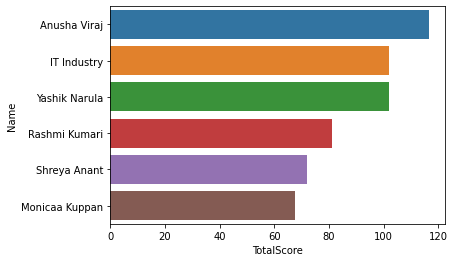

In [42]:
sns.barplot('TotalScore', 'Name', data=resume)

## **Summarizing the Resume**

In [43]:
resumeSummary = [] 
for resumeItem in resumeList:
  summary = summarize(resumeItem, ratio=0.25)
  resumeSummary.append(summary)

# resume['Summary'] = resumeSummary
# resume

In [45]:
resumeSummary[2]

'experience and exposure to Software Development Life Cycle with experience in Requirements Gathering, Design, \n\uf0d8   Good experience in  banking and device management domain specific to both Web and Windows applications  \nDevelopment using OOPs methodologies in J2EE technology.\n\uf0d8  Experience in application development using Servlets, JSP, Java script, SOAP based(WSDL) Web services, \nStruts, XML, XQuery, XPath, DOM, XSLT, SAX, and design patterns \n\uf0d8  Experience in building dynamic web applications using Tomcat, Jboss & web logic application servers \n\uf0d8  A keen learner, implementer with demonstrated abilities in planning & completion of the project.\n\uf0d8  Flexible and versatile to adapt to any new environment and work on any projects with excellent communication \n\uf0d8  Coding, validating, testing server side components and releasing of various modules \n\uf0d8  Solely Responsible for application development ,testing and release in production.\nWEB TECHNOLOGI